In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from XRD import crystal, Element, XRD
import sys
import os
from similarity import Similarity
import csv

def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = []
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles  

def getSpaceGroup(file):
    with open(file, 'r') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    N = len(content)
    separator = ', '
    for line in range(N):
        if '_symmetry_space_group_name_' in content[line]:
            tmp = content[line].split(' ')[1:]
            tmp = separator.join(tmp)
            tmp = tmp.replace(',','')
            tmp =tmp.replace(' ','')  
            return tmp
        

def classifyStructure(file):
    with open(file, 'r') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    N = len(content)
    for line in range(N):
        if '_cell_length_a' in content[line]:
            tmp = content[line].split()
            a = float(tmp[1])
        if '_cell_length_b' in content[line]:
            tmp = content[line].split()
            b = float(tmp[1])
        if '_cell_length_c' in content[line]:
            tmp = content[line].split()
            c = float(tmp[1])
        if '_cell_angle_alpha' in content[line]:
            tmp = content[line].split()
            alpha = float(tmp[1])
        if '_cell_angle_beta' in content[line]:
            tmp = content[line].split()
            beta = float(tmp[1])
        if '_cell_angle_gamma' in content[line]:
            tmp = content[line].split()
            gamma = float(tmp[1])

    
    if a == b == c and alpha == beta == gamma == 90.:
        return 'cubic'
    elif a == b != c and alpha == beta == 90. and gamma == 120.:
        return 'trigonal/hexagonal'
    elif a == b != c and alpha == beta == gamma == 90.:
        return 'tetragonal'
    elif a != b != c and alpha == beta == gamma == 90.:
        return 'orthorhombic'
    elif a != b != c and alpha == gamma == 90. and beta != 90. != 120.:
        return 'monoclinic'
    else:
        return 'triclinic'
    

path = '/Users/sayred1/Research/dXRD/XRD/data'
allFiles = getListOfFiles(path)
allFiles.sort()
poscarFiles = []
cifFiles = []
diffFiles = []


for file in allFiles:
    if 'POSCAR' in file:
        poscarFiles.append(file)
    elif 'cif' in file:
        cifFiles.append(file)
    elif 'diff' in file:
        diffFiles.append(file)


"""
- Take the POSCAR file, load it into pxrd
- plot pxrd diffraction dataset against DIFF file
"""

wavelength = 1.54056
max2theta = 90
fwhm = 0.9
N = 10000
profile = 'gaussian'
dataDict = {}
Sims = []
Sgs = []
clss = []
for poscardata, diffdata, cifFile in zip(poscarFiles,diffFiles,cifFiles):
    """
    Run .cif files through XRD, get profile
    """
    struct = crystal('POSCAR',filename=poscardata)
    xrd1 = XRD(struct, wavelength, max2theta)   
    xrd1.get_profile(xrd1.theta2, xrd1.xrd_intensity,N, profile, fwhm)
    f2thetas = xrd1.g2thetas
    fpeaks = xrd1.gpeaks
    
    """
    Load the diffraction data 
    """
    diff = np.loadtxt(diffdata,str,delimiter='\n')
    size = diff.shape[0]
    xval = []
    yval = []
    i = 0
    while i < size:
        if '2-THETA' in diff[i] and 'INTENSITY' in diff[i]:
            for j in range(i+1, size):
                try:
                    xval.append(float(diff[j].split()[0]))
                    yval.append(float(diff[j].split()[1]))
                except:
                    break
        i+=1
    
    """
    Get profile for diffraction data
    """
    xval = np.array(xval)
    yval = np.array(yval)
    yval/= np.max(yval)
    xrd2 = XRD(struct, wavelength, max2theta)
    xrd2.get_profile(xval, yval,N,profile,fwhm)
    g2thetas = xrd2.g2thetas
    gpeaks = xrd2.gpeaks
    
    S = Similarity(fpeaks, gpeaks, 0.6).calculate()
    classification = classifyStructure(cifFile)
    groupName = getSpaceGroup(cifFile)
    Sgs.append(groupName)
    Sims.append(S)
    clss.append(classification)


with open('valData09.csv', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(zip(Sgs,clss,Sims))

In [3]:
# simulation notes
# do a further analysis, why some structures return better similarities than the others.

# give a defualt number to N, say 10,000
# individual peaks from simulation get profile function f(x)
# this diffraction data are the individual peaks, get profile function g(x)
# compare
# play w/ different fwhm, we should expect exact values of 1 

In [4]:
cubic = []
trig_hex = []
tetra = []
ortho = []
mono = []
tri = []
for s, classification in zip(Sims, clss):
    if classification == 'cubic':
        cubic.append(s)
    elif classification == 'trigonal/hexagonal':
        trig_hex.append(s)
    elif classification == 'tetragonal':
        tetra.append(s)
    elif classification == 'orthorhombic':
        ortho.append(s)
    elif classification == 'monolinic':
        mono.append(s)
    else:
        tri.append(s)
    

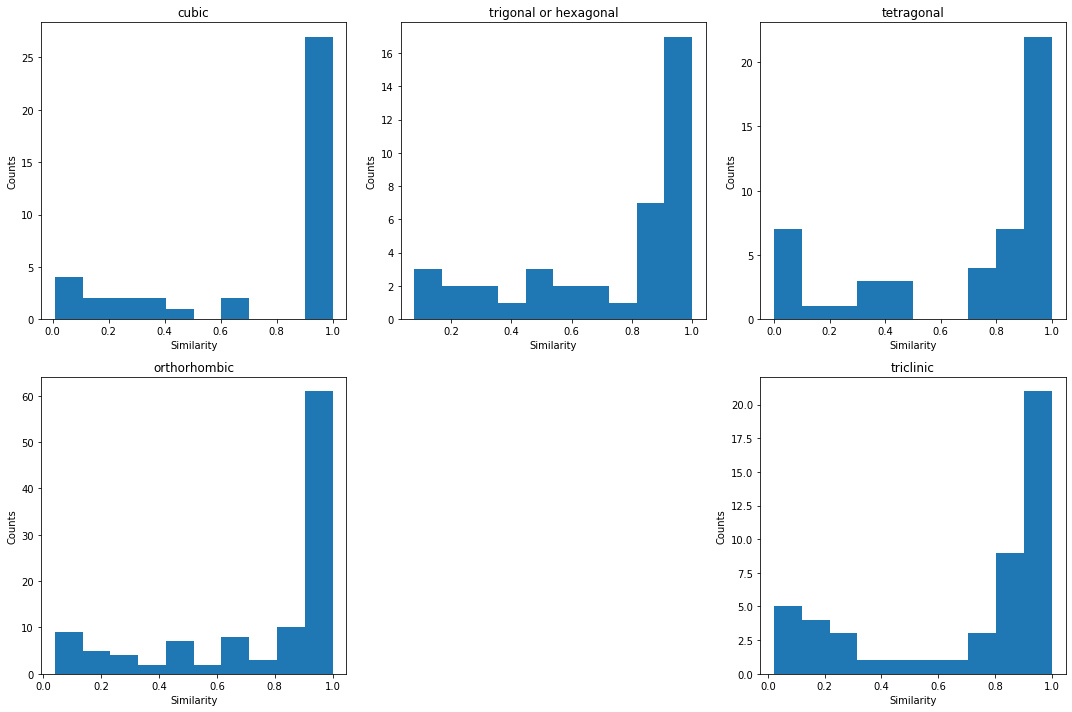

In [5]:
"""
plt.figure(figsize=(15,10))
plt.suptitle('Similarity Histogram')
plt.hist(Sims)
plt.xlabel('Similarity')
plt.ylabel('Counts')
"""
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.hist(cubic)
plt.title('cubic')
plt.xlabel('Similarity')
plt.ylabel('Counts')

plt.subplot(2,3,2)
plt.hist(trig_hex)
plt.title('trigonal or hexagonal')
plt.xlabel('Similarity')
plt.ylabel('Counts')

plt.subplot(2,3,3)
plt.hist(tetra)
plt.title('tetragonal')
plt.xlabel('Similarity')
plt.ylabel('Counts')

plt.subplot(2,3,4)
plt.hist(ortho)
plt.title('orthorhombic')
plt.xlabel('Similarity')
plt.ylabel('Counts')

plt.subplot(2,3,6)
plt.hist(tri)
plt.title('triclinic')
plt.xlabel('Similarity')
plt.ylabel('Counts')
plt.tight_layout()

plt.show()